<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/main/Borisov%20Vasily/Profpatolog_%2B_Hazard_Risk_%2B_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Импортируем основные библиотеки
- Загружаем список колонок датасета, которые мы предполагаем использовать для построния модели.
- Список колонок хранится в файле эксель. Файл эксель - на Яндекс Диске.
- Загружаем Датасет с Яндекс Клауда.

In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
import requests
from urllib.parse import urlencode

# читаем список нужных нам полей с ЯД (файл эксель)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/QWJez3NW1JGGcg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
df_polei = pd.read_excel(download_url)

gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/датасет%20профпатолог%20часть.xlsx', None, quiet=True)
data = pd.read_excel('датасет%20профпатолог%20часть.xlsx')

- Выводим список колонок, у которых количество значений (nunique()) больше 1 и меньше 35
- В модели это не используется. Только как заготовка для будущего анализа и добавления новых колонок в список анализируемых.

In [ ]:
for (columnName, columnData) in data.items():
  if columnData.nunique()>1 and columnData.nunique()<35:
    print(columnName + ' /// ' + str(columnData.nunique()))

- Приводим 6 возможных значений категории годности к 3 (в соответствии с ТЗ).
- Например если в датасете категория годности = "ГоденСКоррекциейЗрения", то мы заменяем это значение на "ОграниченноГоден"

In [ ]:
data=data.replace('ГоденСКоррекциейЗрения','ОграниченноГоден')
data=data.replace('ГоденБезРаботНаВысотах','ОграниченноГоден')
data=data.replace('НуждаетсяВДообследованииИЛечении','ВременноНегоден')

Копируем наш датасет в data500 (на всякий случай оригинальный датасет оставляем без изменений)
Чистим датафрейм data500
 - удаляя лишние колонки (напомню список нужных колонок храним в эксель файле) и
 - строки, у которых неверно заполнена колонка ЗаключениеМК

In [ ]:
data500  = data.copy()
nmp=df_polei['POLE'].tolist()
print(nmp)

for (columnName, columnData) in data500.items():
  if (str(columnName) in nmp)==False:
    data500.pop(columnName)

data500 = data500[data500.ЗаключениеМК.isin(['Годен', 'ВременноНегоден', 'ОграниченноГоден']) == True ]

['КлиентПолПредставление', 'Профессия', 'ЗаключениеМК', 'ВредныеФакторы', 'Рентгенология1_Заключение_ЗначениеПредставление', 'ПсихиатрияНаркология1_МКБ101', 'ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление', 'Офтальмология1_МКБ101', 'Офтальмология1_ГоденНегоден_ЗначениеПредставление', 'Оториноларингология1_МКБ101', 'Оториноларингология1_ГоденНегоден_ЗначениеПредставление', 'ХирургНеИсп1_МКБ101', 'ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление', 'Гинекология1_МКБ101', 'Гинекология1_ГоденНегоден_ЗначениеПредставление', 'Стоматология1_МКБ101', 'Стоматология1_ГоденНегоден_ЗначениеПредставление', 'Терапия1_ГоденНегоден_ЗначениеПредставление', 'Дерматовенерология1_МКБ101', 'Дерматовенерология1_ГоденНегоден_ЗначениеПредставление', 'Рентгенология1_МКБ101', 'Рентгенология1_ПрофнепригодностьВременная1', 'Неврология1_МКБ101', 'Неврология1_ПрофнепригодностьВременная1', 'Неврология1_ГоденНегоден_ЗначениеПредставление', 'Терапия1_МКБ101', 'Хирургия1_МКБ101', 'Хирургия1_ГоденНегоден_Значени

Формируем списки:
- ListOfColumnNames - наименования колонок
- ListOfColumnValues - значения колонок
- ListOfColumnNames_Lists - значения колонки, в которой содержится список значений (пока это одна колонка - ВредныеФакторы)
- В дальнейшем мы будем использовать эту информацию для векторизации данных нашего датасета

In [ ]:
razdelitel = ","
columnsWithLists = ['ВредныеФакторы']
ListOfColumnNames = []
ListOfColumnValues = []
ListOfColumnNames_Lists = []
for (columnName, columnData) in data500.items():
  ListOfColumnNames.append(columnName)
  if columnName in columnsWithLists:
    ListOfColumnValues.append(list(set(razdelitel.join(data500[columnName].tolist()).splitlines()[0].split(','))))
  else:
    ListOfColumnValues.append(list(data500[columnName].dropna().unique().flatten()))

Приводим наш датасет к векторам

In [ ]:
def get_vector(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  if vectorLen < 25:
    while i < vectorLen:
      if (ListOfColumnValues[columnNumber][i] == row[columnNumber]):
        Null_or_One = 1
      else:
        Null_or_One = 0
      vector = np.hstack([vector, Null_or_One])
      i+=1
  return vector


def get_vector_from_list(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  rowToList = ((row[columnNumber].split(',')))
  while i < vectorLen:
    if (ListOfColumnValues[columnNumber][i] in rowToList):
      Null_or_One = 1
    else:
      Null_or_One = 0
    vector = np.hstack([vector, Null_or_One])
    i+=1
  return vector


def extract_row_data(row):
  x1_data = []
  x2_data = []
  y_data = []
  for columnName in ListOfColumnNames:
    columnNumber = ListOfColumnNames.index(columnName)
    if columnName == 'ЗаключениеМК':
      y_data = np.hstack([y_data, get_vector(row, columnNumber)])
    elif columnName in columnsWithLists:
      x2_data = np.hstack([x2_data, get_vector_from_list(row, columnNumber)])
    else:
      x1_data = np.hstack([x1_data, get_vector(row, columnNumber)])
  return x1_data, x2_data, y_data



def construct_train_data(row_list):
    x1_data = []
    x2_data = []
    y_data = []
    for row in row_list:
      x1, x2, y = extract_row_data(row)
      x1_data.append(x1)
      x2_data.append(x2)
      y_data.append(y)
    return np.array(x1_data), np.array(x2_data), np.array(y_data)


x1_data500, x2_data500, y_data500 = construct_train_data(data500.values)

Импортируем модель FastText. Модель большая (> 7 Гб), поэтому делал все локально

In [ ]:
import fasttext
ft = fasttext.load_model('E:\cc.ru.300.bin')

Преобразуем профессию сотрудника в вектор, используя fasttext

In [ ]:
x3_data = []
for row in data500.values:
  wordVector = ft.get_word_vector(str(row[1]))
  x3_data.append(wordVector)
x3_data500 = np.array(x3_data)

In [ ]:
# Разбиение наборов на общую и тестовую выборки
x1_all, x1_test, x2_all, x2_test, x3_all, x3_test, y_all, y_test = train_test_split(
                                                x1_data500,
                                                x2_data500,
                                                x3_data500,
                                                y_data500,
                                                test_size=0.1,
                                                shuffle=True,
                                                random_state = 6)

# Разбиение общей выборки на обучающую и проверочную
x1_train, x1_val, x2_train, x2_val, x3_train, x3_val, y_train, y_val = train_test_split(
                                                  x1_all,
                                                  x2_all,
                                                  x3_all,
                                                  y_all,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state = 6)

Запускаем модель

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, CategoryEncoding, Normalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image


%matplotlib inline

# Разбиение наборов на общую и тестовую выборки
x1_all, x1_test, x2_all, x2_test, x3_all, x3_test, y_all, y_test = train_test_split(
                                                x1_data500,
                                                x2_data500,
                                                x3_data500,
                                                y_data500,
                                                test_size=0.1,
                                                shuffle=True,
                                                random_state = 6)

# Разбиение общей выборки на обучающую и проверочную
x1_train, x1_val, x2_train, x2_val, x3_train, x3_val, y_train, y_val = train_test_split(
                                                  x1_all,
                                                  x2_all,
                                                  x3_all,
                                                  y_all,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state = 6)


input1 = Input((x1_train.shape[1],))
input2 = Input((x2_train.shape[1],))
input3 = Input((x3_train.shape[1],))

x1 = input1                               # Ветка 1
x1 = Normalization()(x1)
x1 = Dense(256, activation="linear")(x1)
x1 = Activation('relu')(x1)
x1 = Dense(32, activation="linear")(x1)
x1 = Activation('relu')(x1)
x1 = Dense(3, activation="linear")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(500, activation="relu")(x2)

x3 = input3                               # Ветка 3
x3 = Dense(50, activation="relu")(x3)
x3 = Dense(500, activation="relu")(x3)

x23 = concatenate([x2, x3])             # Объединение 3 веток
x23 = Dense(15, activation='tanh')(x23) # Промежуточный слой
x = concatenate([x1, x23])              # Объединение 3 веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.1)(x)
x = Dense(3, activation='softmax')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

# model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['mae'])
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit([x1_train, x2_train, x3_train],
                           y_train,
                           batch_size=256,
                           epochs=150,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/150
5/5 [==============================] - 7s 268ms/step - loss: 1.0342 - accuracy: 0.6648 - val_loss: 0.8203 - val_accuracy: 0.9215
Epoch 2/150
5/5 [==============================] - 1s 112ms/step - loss: 0.7170 - accuracy: 0.9037 - val_loss: 0.5183 - val_accuracy: 0.9215
Epoch 3/150
5/5 [==============================] - 1s 116ms/step - loss: 0.4713 - accuracy: 0.9019 - val_loss: 0.3543 - val_accuracy: 0.9215
Epoch 4/150
5/5 [==============================] - 0s 105ms/step - loss: 0.4153 - accuracy: 0.9019 - val_loss: 0.3312 - val_accuracy: 0.9215
Epoch 5/150
5/5 [==============================] - 0s 99ms/step - loss: 0.4046 - accuracy: 0.9037 - val_loss: 0.3296 - val_accuracy: 0.9215
Epoch 6/150
5/5 [==============================] - 1s 115ms/step - loss: 0.4054 - accuracy: 0.9028 - val_loss: 0.3173 - val_accuracy: 0.9215
Epoch 7/150
5/5 [==============================] - 1s 107ms/step - loss: 0.4018 - accuracy: 0.9009 - val_loss: 0.3072 - val_accuracy: 0.9215
Epoch 8/150
5/

Рисуем график модели

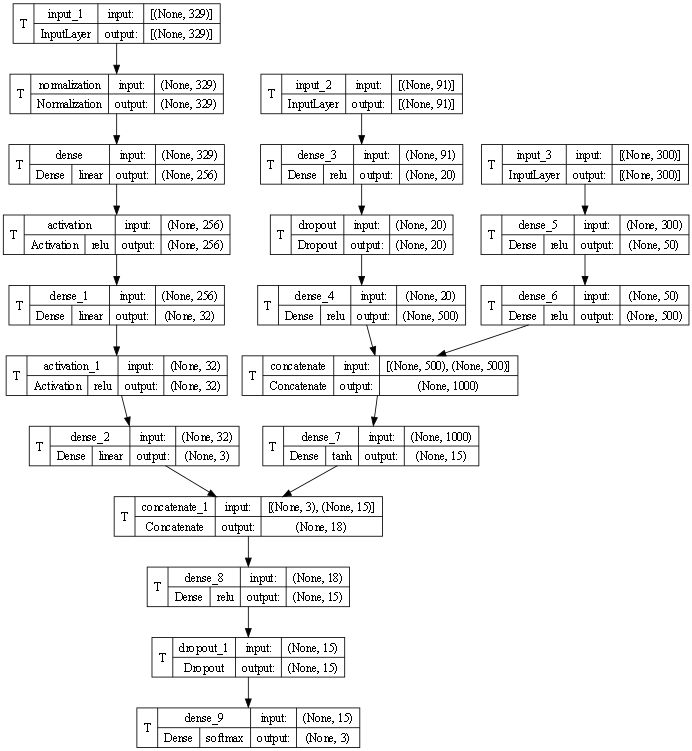

In [ ]:
utils.plot_model(model_final, show_shapes=True, show_layer_names=True, dpi=60, show_layer_activations=True, show_trainable=True)

5/5 [==============================] - 0s 10ms/step - loss: 0.5128 - accuracy: 0.9085


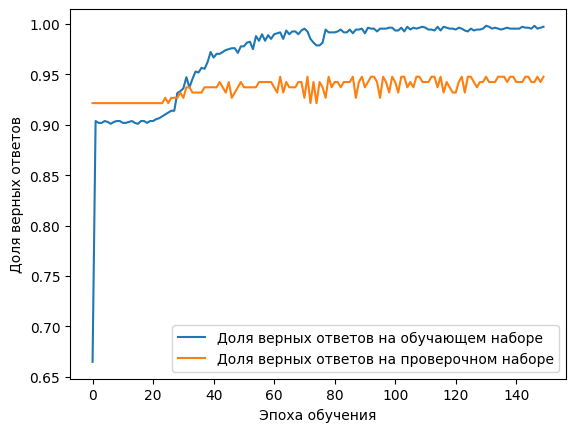

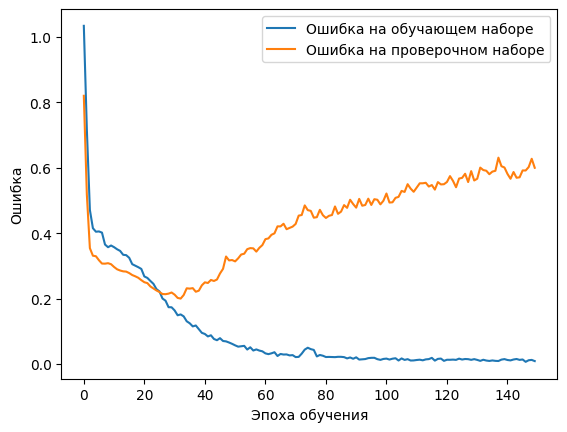

In [ ]:
scores = model_final.evaluate([x1_test, x2_test, x3_test],
                        y_test,
                        verbose=1
                        )
scores2 = model_final.evaluate([x1_val, x2_val, x3_val],
                        y_val,
                        verbose=1
                        )
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()


plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()